# General Instructions to students:

1. There are 5 types of cells in this notebook. The cell type will be indicated within the cell.
    1. Markdown cells with problem written in it. (DO NOT TOUCH THESE CELLS) (**Cell type: TextRead**)
    2. Python cells with setup code for further evaluations. (DO NOT TOUCH THESE CELLS) (**Cell type: CodeRead**)
    3. Python code cells with some template code or empty cell. (FILL CODE IN THESE CELLS BASED ON INSTRUCTIONS IN CURRENT AND PREVIOUS CELLS) (**Cell type: CodeWrite**)
    4. Markdown cells where a written reasoning or conclusion is expected. (WRITE SENTENCES IN THESE CELLS) (**Cell type: TextWrite**)
    5. Temporary code cells for convenience and TAs. (YOU MAY DO WHAT YOU WILL WITH THESE CELLS, TAs WILL REPLACE WHATEVER YOU WRITE HERE WITH OFFICIAL EVALUATION CODE) (**Cell type: Convenience**)
    
2. You are not allowed to insert new cells in the submitted notebook.

3. You are not allowed to import any extra packages.

4. The code is to be written in Python 3.6 syntax. Latest versions of other packages maybe assumed.

5. In CodeWrite Cells, the only outputs to be given are plots asked in the question. Nothing else to be output/print. 

6. If TextWrite cells ask you to give accuracy/error/other numbers you can print them on the code cells, but remove the print statements before submitting.

7. The convenience code can be used to check the expected syntax of the functions. At a minimum, your entire notebook must run with "run all" with the convenience cells as it is. Any runtime failures on the submitted notebook as it is will get zero marks.

8. All code must be written by yourself. Copying from other students/material on the web is strictly prohibited. Any violations will result in zero marks.

9. All datasets will be given as .npz files, and will contain data in 4 numpy arrays :"X_train, Y_train, X_test, Y_test". In that order. The meaning of the 4 arrays can be easily inferred from their names.

10. All plots must be labelled properly, all tables must have rows and columns named properly.

11. Before subbmission ensure that you submit with the outputs (do not clear the outputs), so that when evaluating we can run selectively.

12. Before submission ensure that the path for the folder containing the data is "../../Data/" 


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
import matplotlib as mpl
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

# 1. Logistic Regression 

Write code for doing logistic regression below. Also write code for choosing best hyperparameters for each kernel type (use a part of training set as validation set). 

The range of hyperparameters is typically chosen on a log scale e.g. 1e-4, 1e-3, 1e-2... 1e3.

Write code for running in the cell after (You may be asked to demonstrate your code during the viva using this cell.)

In text cell after that report the following numbers you get by running appropriate code:

For each classification data set report the best kernel and regularisation parameters for linear, RBF and Poly kernels. (Linear has no kernel parameter.) Report the training and test zero-one error for those hyperparameters. 

For each given hyperparameter setting (kernel and regularisation) you will have to do some exploring to find the right learning rate to use in gradient descent. The optimisation learning rate is not a model hyperparameter and hence can be chosen based on just the training set. i.e. choose the learning rate for which the training loss decreases the most.

For the synthetic classification datasets (dataset_A and dataset_B) in 2-dimensions, also illustrate the learned classifier for each kernel setting. Do this in the last codeWrite cell for this question.


In [2]:
# CodeWrite 
# Write logistic regression code from scratch. Use gradient descent.
# Only write functions here

def calculate_kernel_matrix(X, kernel, kernel_param):
    """
    Calculate the kernel matrix for the data X
    """
    if(kernel == 'linear'):
        return np.matmul(X, X.T)
    elif(kernel == 'poly'):
        return (1 + np.matmul(X, X.T)) ** kernel_param
    elif(kernel == 'rbf'):
        return np.exp(-kernel_param * (np.sum(X ** 2, axis = 1) + np.sum(X ** 2, axis = 1)[:, np.newaxis] - 2 * np.matmul(X, X.T)))

def calculate_kernel_values(X, x, kernel, kernel_param):
    """
    Calculate the kernel values between x and all the points in X
    """
    if kernel == 'linear':
        return np.dot(X, x)
    elif kernel == 'poly':
        return (1 + np.dot(X, x)) ** kernel_param
    elif kernel == 'rbf':
        return np.exp(-kernel_param * (np.sum(X ** 2, axis = 1) + np.sum(x ** 2) - 2 * np.dot(X, x)))

def train_pred_logistic_regression(X, Y, kernel='linear', reg_param=0., kernel_param=1., num_iter_gd=100):
    """
    Arguments:
    X : (n,d) shape numpy array
    Y : (n,)  shape numpy array
    X_test : (m,d) shape numpy array
    kernel = 'linear' or 'rbf' or 'poly' 
    reg_param = $\ lambda$
    num_iter_gd = number of GD iterations.

    Returns the result of kernel logistic regression :
    alpha: Vector of solutions for the dual. Numpy array of shape (n,)

    Primal problem:
    $ \ min_w  \ sum_{i=1}^n \ log(1+\ exp(-y_i* \ w^\ top \phi(\ x_i)))  + \ frac{\ lambda}{2} ||\ w||^2 $

    the dual of which is

    $ \ min_alpha \ sum_{i=1}^n \ log(1+\ exp(-y_i* \ alpha^\ top K_{:,i} ))  + \ frac{\ lambda}{2} \ alpha^\ top K \ alpha $
    where $\ phi$ is the feature got by the kernel.

    Where K is the nxn kernel matrix computed on the training data.

    The kernel is defined by the kernel_param:
    If kernel=linear: K(\ u,\ v) = \ u^\ top \ v  
    If kernel=poly:  K(\ u,\ v) = (1+\ u^\ top \ v)^(kernel_param)
    If kernel=rbf:  K(\ u,\ v) = \ exp(-kernel_param*||\ u-\ v||^2)
    """
    kernel_X = calculate_kernel_matrix(X, kernel, kernel_param)
    alpha = np.zeros(X.shape[0])
    eta = 0.1
    
    for _ in range(num_iter_gd):
        delta_R_alpha = reg_param * np.matmul(kernel_X, alpha) - np.sum((1 - 1 / (1 + np.exp(-Y * np.matmul(kernel_X, alpha)))) * Y * kernel_X, axis=1)
        alpha = alpha - eta * delta_R_alpha
    
    return alpha

def test_pred(alpha, train_X, test_X, kernel, kernel_param):
    """
    Return the predictions on test_X using the learnt alphas
    """
    return np.array([np.sign(np.dot(alpha, calculate_kernel_values(train_X, test_X[i], kernel, kernel_param))) for i in range(test_X.shape[0])])

In [3]:
# CodeWrite : Use the functions above to do validation to get best hyperparameters 
# (i.e. kernel_param and regularisation_param).
# Also, get the numbers you report below.

kernels = ['linear', 'poly', 'rbf']
num_iter = 100

best_kernel_params = {'A':{}, 'B':{}, 'C':{}, 'D':{}}
best_reg_params = {'A':{}, 'B':{}, 'C':{}, 'D':{}}

def find_best_parameter(kernel, X_train, Y_train, X_val, Y_val):
    best_kernel_param, best_reg_param, best_accuracy = 0, 0, 0
    kernel_params, reg_params = [], []

    if kernel == 'linear':
        kernel_params = [1]
        reg_params = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
    elif kernel == 'poly':
        kernel_params = [1, 2, 4, 6, 8, 10]
        reg_params = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
    elif kernel == 'rbf':
        kernel_params = [1e-3, 1e-2, 1e-1, 1, 2, 4, 10, 100]
        reg_params = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]

    for kernel_param in kernel_params:
        for reg_param in reg_params:
            alpha = train_pred_logistic_regression(X_train, Y_train, kernel=kernel, reg_param=reg_param, kernel_param=kernel_param, num_iter_gd=num_iter)
            pred = test_pred(alpha, X_train, X_val, kernel=kernel, kernel_param=kernel_param)
            pred[pred == 0] = 1
            accuracy = np.mean(pred == Y_val)
            if accuracy > best_accuracy:
                best_kernel_param, best_reg_param, best_accuracy = kernel_param, reg_param, accuracy
    return best_kernel_param, best_reg_param, best_accuracy

for a in ['A', 'B', 'C', 'D']:
    data = np.load('../../Data/dataset_{}.npz'.format(a))
    X_train, Y_train = data['arr_0'], data['arr_1']
    X_test, Y_test = data['arr_2'], data['arr_3']

    X_train_full, Y_train_full = X_train, Y_train

    print("Dataset {}\n".format(a))
    X_train, X_val = X_train[:int(0.8 * X_train.shape[0])], X_train[int(0.8 * X_train.shape[0]):]
    Y_train, Y_val = Y_train[:int(0.8 * Y_train.shape[0])], Y_train[int(0.8 * Y_train.shape[0]):]

    for kernel in kernels:
        best_kernel_param, best_reg_param, best_accuracy = find_best_parameter(kernel, X_train, Y_train, X_val, Y_val)
        print("Kernel: {}, best_kernel_param: {}, best_reg_param: {}, best_val_accuracy: {}".format(kernel, best_kernel_param, best_reg_param, best_accuracy))
        alpha = train_pred_logistic_regression(X_train_full, Y_train_full, kernel, best_reg_param, best_kernel_param)
        best_kernel_params[a][kernel] = best_kernel_param
        best_reg_params[a][kernel] = best_reg_param
        train_pred = test_pred(alpha, X_train_full, X_train_full, kernel, best_kernel_param)
        train_pred[train_pred == 0] = 1
        train_accuracy = np.sum(train_pred == Y_train_full)/Y_train_full.shape[0]
        print("Train accuracy: {}".format(train_accuracy))
        pred = test_pred(alpha, X_train_full, X_test, kernel, best_kernel_param)
        pred[pred == 0] = 1
        accuracy = np.sum(pred == Y_test)/Y_test.shape[0]
        print("Test accuracy: {}\n".format(accuracy))

Dataset A

Kernel: linear, best_kernel_param: 1, best_reg_param: 0.0001, best_val_accuracy: 0.88
Train accuracy: 0.828
Test accuracy: 0.842

Kernel: poly, best_kernel_param: 2, best_reg_param: 0.0001, best_val_accuracy: 0.8766666666666667
Train accuracy: 0.8693333333333333
Test accuracy: 0.844

Kernel: rbf, best_kernel_param: 1, best_reg_param: 1e-06, best_val_accuracy: 1.0
Train accuracy: 0.9986666666666667
Test accuracy: 0.994

Dataset B

Kernel: linear, best_kernel_param: 1, best_reg_param: 1e-06, best_val_accuracy: 0.74
Train accuracy: 0.7493333333333333
Test accuracy: 0.758

Kernel: poly, best_kernel_param: 4, best_reg_param: 0.0001, best_val_accuracy: 0.8366666666666667
Train accuracy: 0.824
Test accuracy: 0.806

Kernel: rbf, best_kernel_param: 2, best_reg_param: 1e-06, best_val_accuracy: 0.8366666666666667
Train accuracy: 0.7753333333333333
Test accuracy: 0.746

Dataset C

Kernel: linear, best_kernel_param: 1, best_reg_param: 1e-06, best_val_accuracy: 0.5033333333333333
Train ac

TextWrite Cell: Give your observations and the list of hyperparameter choices and train zero-one error and test zero-one error for all three kernel choices, for all 4 datasets (2 real world and 2 synthetic). 

### Observations

1. The best kernel for almost all the datasets is RBF. This is because the data is non-linearly separable and RBF kernel is able to capture the non-linearity in the data.

2. In the dataset B, all the kernels perform equally. This is because the data is overlapping and not perfectly separable.

3. In dataset A and C, the rbf kernel performs a lot better than the linear and poly kernel. 

4. The regularization parameters for all the kernel types and datasets are low, this shows that the data is not overfitting and the model is not overfitting the data.

5. The validation error is similar to the testing error for all the datasets. This shows that the model is not overfitting the data.

### Best hyperparameters for each kernel type
- Used 20 % of training data as validation set

- KP - Kernel Parameter

- RP - Regularisation Parameter

| Dataset | Kernel | Best KP | Best RP | Train Accuracy | Test Accuracy |
|:-------:|:------:|:-------:|:-------:|:--------------:|:-------------:|
| A       | Linear | 1       | 1e-4    | 0.828          | 0.842         |
| A       | Poly   | 2       | 1e-4    | 0.869          | 0.844         |
| A       | RBF    | 1       | 1e-6    | 0.998          | 0.994         |
| B       | Linear | 1       | 1e-6    | 0.749          | 0.758         |
| B       | Poly   | 4       | 1e-4    | 0.824          | 0.806         |
| B       | RBF    | 2       | 1e-6    | 0.775          | 0.746         |
| C       | Linear | 1       | 1e-6    | 0.502          | 0.511         |
| C       | Poly   | 1       | 1e-6    | 0.502          | 0.511         |
| C       | RBF    | 0.1     | 1e-6    | 1.0            | 0.969         |
| D       | Linear | 1       | 1e-6    | 0.567          | 0.769         |
| D       | Poly   | 1       | 1e-6    | 0.567          | 0.769         |
| D       | RBF    | 0.001   | 1e-6    | 0.992          | 0.905         |

### Best Kernel and its parameters for each dataset

| Dataset | Best Kernel | KP | RP |
|:-------:|:-----------:|:--:|:--:|
| A       | RBF         | 1  | 1e-6 |
| B       | Poly        | 4  | 1e-4 |
| C       | RBF         | 0.1 | 1e-6 |
| D       | RBF         | 0.001 | 1e-6 |

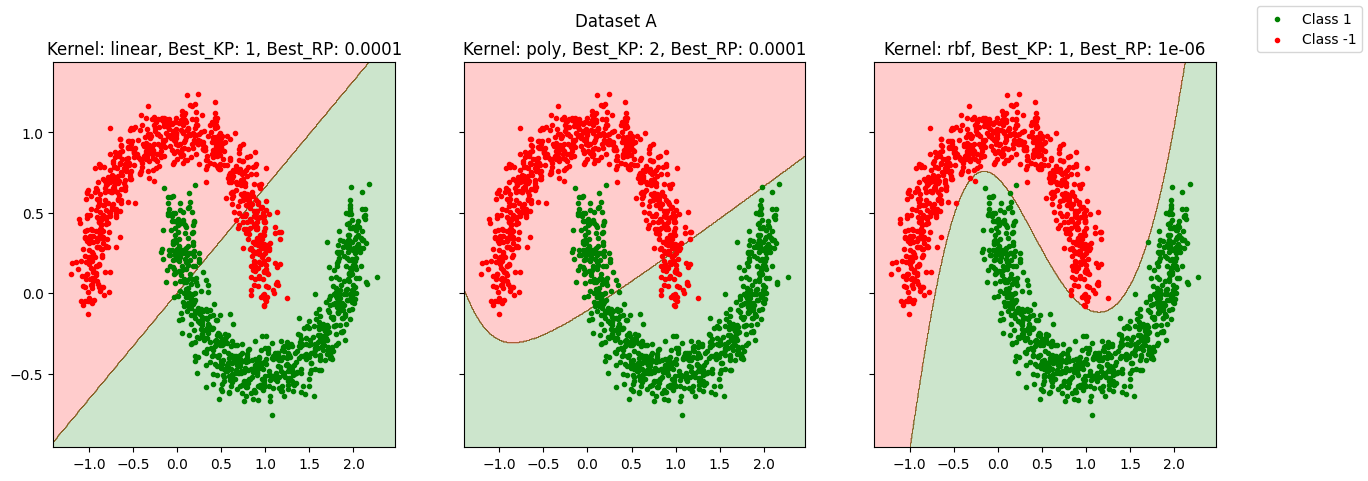

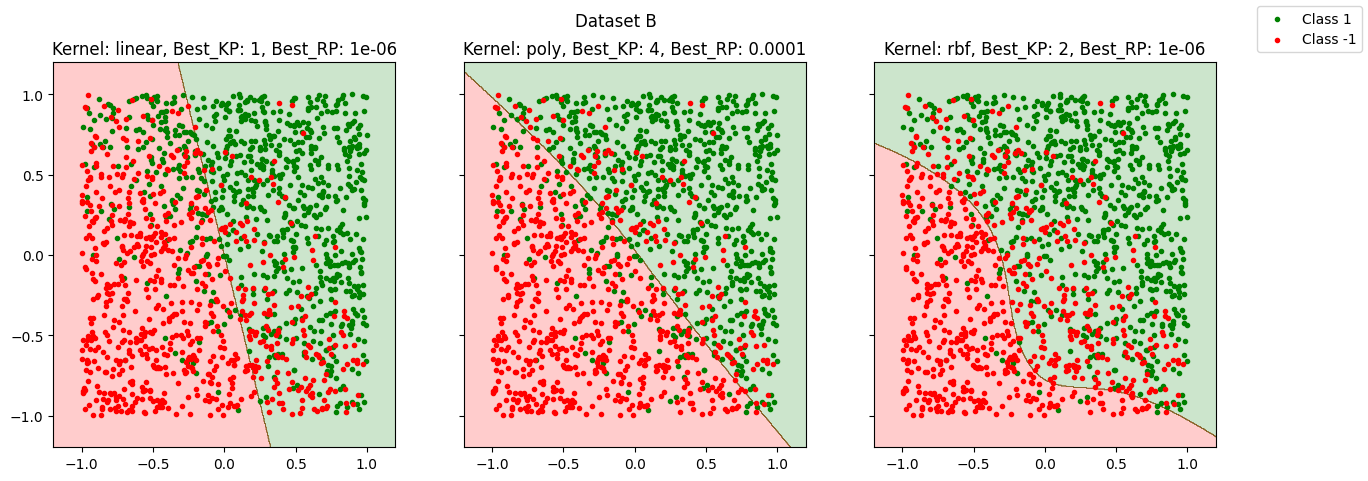

In [4]:
# Codewrite cell: Generate plots of learned classifier for all three kernel types, on dataset_A and datasset_B.
# Plots should give both the learned classifier and the train data. 
# Similar to  Bishop Figure 4.5 (with just two classes here.)
# Total number of plots = 3 * 2 = 6

kernels = ['linear', 'poly', 'rbf']

for a in ['A', 'B']:
    data = np.load('../../Data/dataset_{}.npz'.format(a))
    X_train, Y_train = data['arr_0'], data['arr_1']
    X_test, Y_test = data['arr_2'], data['arr_3']
    minX, maxX = np.min(X_train[:, 0]), np.max(X_train[:, 0])
    minY, maxY = np.min(X_train[:, 1]), np.max(X_train[:, 1])
    points = 500
    X, Y = np.meshgrid(np.linspace(minX-0.2, maxX+0.2, points), np.linspace(minY-0.2, maxY+0.2, points))
    X_plotter = np.c_[X.ravel(), Y.ravel()]

    fig, ax = plt.subplots(1, 3, sharey=True, figsize=(15, 5))
    line = [0, 0]
    for i, kernel in enumerate(kernels):
        alpha = train_pred_logistic_regression(X_train, Y_train, kernel, best_reg_params[a][kernel], best_kernel_params[a][kernel])
        pred = test_pred(alpha, X_train, X_plotter, kernel, best_kernel_params[a][kernel])
        pred[pred == 0] = 1
        Z = pred.reshape(X.shape)
        ax[i].contourf(X, Y, Z, colors=['red', 'green'], alpha=0.2)
        line[0] = ax[i].scatter(X_train[Y_train == 1, 0], X_train[Y_train == 1, 1], color='green', marker='.')
        line[1] = ax[i].scatter(X_train[Y_train == -1, 0], X_train[Y_train == -1, 1], color='red', marker='.')
        ax[i].set_title("Kernel: {}, Best_KP: {}, Best_RP: {}".format(kernel, best_kernel_params[a][kernel], best_reg_params[a][kernel]))
    fig.legend(line, ['Class 1', 'Class -1'], loc='upper right')
    fig.suptitle("Dataset {}".format(a))
    plt.show()


# 2. SVM

Write code for learning SVM below. Also write code for choosing best hyperparameters for each kernel type. You may use sklearn.svm for this purpose. (use a part of training set as validation set)

Write code for running in the cell after (You may be asked to demonstrate your code during the viva using this cell.)

In text cell after that report the following numbers you get by running appropriate code:

For each classification data set report the best kernel and regularisation parameters for linear, RBF and Poly kernels. (Linear has no kernel parameter.) Report the training and test zero-one error for those hyperparameters.

For the synthetic classification datasets in 2-dimensions, also illustrate the learned classifier for each kernel setting. Do this in the last codeWrite cell for this question.

In [2]:
# CodeWrite cell
# Write SVM classifier using SKlearn
# write only functions here

def train_svm(X, Y, kernel='rbf', reg_param=1.0, kernel_param=1.0):
    """
    Train SVM classifier using sklearn.svm.SVC
    """
    clf = svm.SVC()
    if kernel == 'linear':
        clf = svm.SVC(kernel=kernel, C=reg_param)
    elif kernel == 'poly':
        clf = svm.SVC(kernel=kernel, degree=kernel_param, C=reg_param, coef0=1.0)
    elif kernel == 'rbf':
        clf = svm.SVC(kernel=kernel, gamma=kernel_param, C=reg_param)
    clf.fit(X, Y)
    return clf

def predict_value(clf, X):
    """
    Predict using the SVM classifier
    """
    return clf.predict(X)

In [3]:
# CodeWrite cell
# Write code here for doing validation (for kernel_param and regularisation_param)
# on a subset of the training set. 
# Also for generating the numbers that you report below.
    
kernels = ['linear', 'poly', 'rbf']

best_kernel_params = {'A': {}, 'B': {}, 'C': {}, 'D': {}}
best_reg_params = {'A': {}, 'B': {}, 'C': {}, 'D': {}}

def find_best_parameter(kernel, X_train, Y_train, X_val, Y_val):
    best_kernel_param, best_reg_param, best_accuracy = None, None, 0
    kernel_params, reg_params = [], []
    
    if kernel == 'linear':
        kernel_params = [1]
        reg_params = [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
    elif kernel == 'poly':
        kernel_params = [1, 2, 4, 6, 8]
        reg_params = [1e-4, 1e-3, 1e-2, 1e-1, 1, 10]
    elif kernel == 'rbf':
        kernel_params = [1e-3, 1e-2, 1e-1, 1, 2, 4, 10, 100]
        reg_params = [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]

    for kernel_param in kernel_params:
        for reg_param in reg_params:
            clf = train_svm(X_train, Y_train, kernel, reg_param=reg_param, kernel_param=kernel_param)
            pred = predict_value(clf, X_val)
            pred[pred == 0] = 1
            accuracy = np.mean(pred == Y_val)
            if accuracy > best_accuracy:
                best_kernel_param, best_reg_param, best_accuracy = kernel_param, reg_param, accuracy
    return best_kernel_param, best_reg_param, best_accuracy

for a in ['A', 'B', 'C', 'D']:
    dataset = "../../Data/dataset_" + a + ".npz"
    data = np.load(dataset)

    print("Dataset {}\n".format(a))
    X_train, Y_train = data['arr_0'], data['arr_1']
    X_test, Y_test = data['arr_2'], data['arr_3']

    rand_indices = np.random.permutation(X_train.shape[0])
    X_train, X_val = X_train[rand_indices[:int(X_train.shape[0] * 0.8)]], X_train[rand_indices[int(X_train.shape[0] * 0.8):]]
    Y_train, Y_val = Y_train[rand_indices[:int(Y_train.shape[0] * 0.8)]], Y_train[rand_indices[int(Y_train.shape[0] * 0.8):]]

    for kernel in kernels:
        best_kernel_param, best_reg_param, best_accuracy = find_best_parameter(kernel, X_train, Y_train, X_val, Y_val)
        print("Kernel: {}, best_kernel_param: {}, best_reg_param: {}, val_accuracy: {}".format(kernel, best_kernel_param, best_reg_param, best_accuracy))
        clf = train_svm(X_train, Y_train, kernel=kernel, reg_param=best_reg_param, kernel_param=best_kernel_param)
        best_kernel_params[a][kernel] = best_kernel_param
        best_reg_params[a][kernel] = best_reg_param           
        pred_train = predict_value(clf, X_train)
        pred_train[pred_train == 0] = 1
        print("Train accuracy: {}".format(np.mean(pred_train == Y_train)))
        pred = predict_value(clf, X_test)
        pred[pred == 0] = 1
        accuracy = np.mean(pred == Y_test)
        print("Test accuracy: {}\n".format(accuracy))

Dataset A

Kernel: linear, best_kernel_param: 1, best_reg_param: 0.1, val_accuracy: 0.87
Train accuracy: 0.8683333333333333
Test accuracy: 0.864

Kernel: poly, best_kernel_param: 4, best_reg_param: 0.01, val_accuracy: 0.9966666666666667
Train accuracy: 0.99
Test accuracy: 0.992

Kernel: rbf, best_kernel_param: 1, best_reg_param: 1, val_accuracy: 1.0
Train accuracy: 0.9983333333333333
Test accuracy: 0.998

Dataset B

Kernel: linear, best_kernel_param: 1, best_reg_param: 0.01, val_accuracy: 0.8433333333333334
Train accuracy: 0.825
Test accuracy: 0.82

Kernel: poly, best_kernel_param: 1, best_reg_param: 0.01, val_accuracy: 0.8366666666666667
Train accuracy: 0.8266666666666667
Test accuracy: 0.808

Kernel: rbf, best_kernel_param: 0.01, best_reg_param: 1, val_accuracy: 0.8366666666666667
Train accuracy: 0.8275
Test accuracy: 0.804

Dataset C

Kernel: linear, best_kernel_param: 1, best_reg_param: 0.0001, val_accuracy: 0.9233333333333333
Train accuracy: 0.8991666666666667
Test accuracy: 0.902

TextWrite Cell: Give your observations and the list of hyperparameter choices and train zero-one error  and test zero-one error for all three kernel choices, for all 4 datasets (2 real world and 2 synthetic).

### Observations

1. RBF performs very well on almost all datasets.

2. The regularization parameters for all the kernel types and datasets are low, this shows that the data is not overfitting and the model is not overfitting the data.

3. The validation error is similar to the testing error for all the datasets. This shows that the model is not overfitting the data.

4. The dataset seems to be seperable properly by the rbf kernel as the accuracy is very high for the datasets A and C.

5. The dataset B is not linearly seperable thus none of the kernels are able to classify it better than 80% accuracy.

6. The dataset C seems like a non-linearly seperable data but the rbf kernel is able to classify it with 98% accuracy, this maybe some spherical data.

### Best hyperparameters for each kernel type
- Used 20 % of training data as validation set

- KP - Kernel Parameter

- RP - Regularisation Parameter

- The validation set was chosen randomly from the training set each time so the results may vary slightly but the values will be similar.

| Dataset | Kernel | Best KP | Best RP | Train Accuracy | Test Accuracy |
|:-------:|:------:|:-------:|:-------:|:--------------:|:-------------:|
| A       | Linear | 1       | 0.1     | 0.869          | 0.864         |
| A       | Poly   | 4       | 10      | 1.0            | 0.998         |
| A       | RBF    | 1       | 100     | 1.0            | 0.998         |
| B       | Linear | 1       | 0.01    | 0.825          | 0.812         |
| B       | Poly   | 2       | 0.01    | 0.823          | 0.812         |
| B       | RBF    | 4       | 0.01    | 0.821          | 0.81          |
| C       | Linear | 1       | 0.1     | 0.935          | 0.885         |
| C       | Poly   | 4       | 0.1     | 0.996          | 0.959         |
| C       | RBF    | 0.001   | 1       | 1.0            | 0.976         |
| D       | Linear | 1       | 0.0001  | 0.925          | 0.946         |
| D       | Poly   | 8       | 10      | 0.953          | 0.952         |
| D       | RBF    | 0.001   | 1       | 0.978          | 0.887         |

### Best Kernel and its parameters for each dataset

| Dataset | Best Kernel | KP | RP |
|:-------:|:-----------:|:--:|:--:|
| A       | Poly        | 4  | 10 |
| A       | RBF         | 1  | 100|
| B       | Linear      | 1  | 0.01 |
| B       | Poly        | 2  | 0.01 |
| C       | RBF         | 0.001 | 1 |
| D       | Poly        | 8  | 10 |

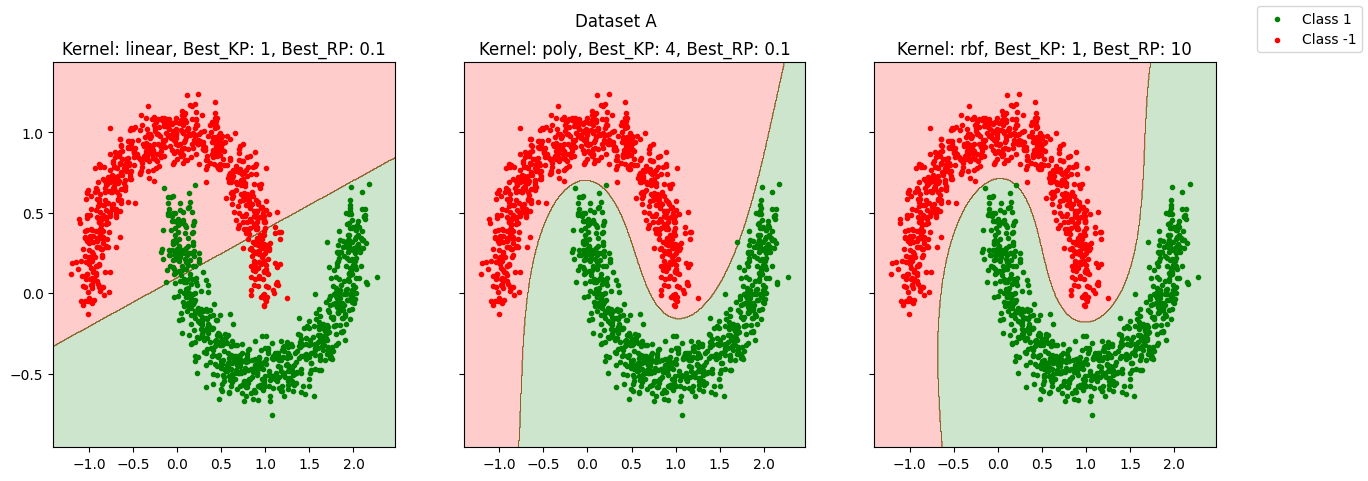

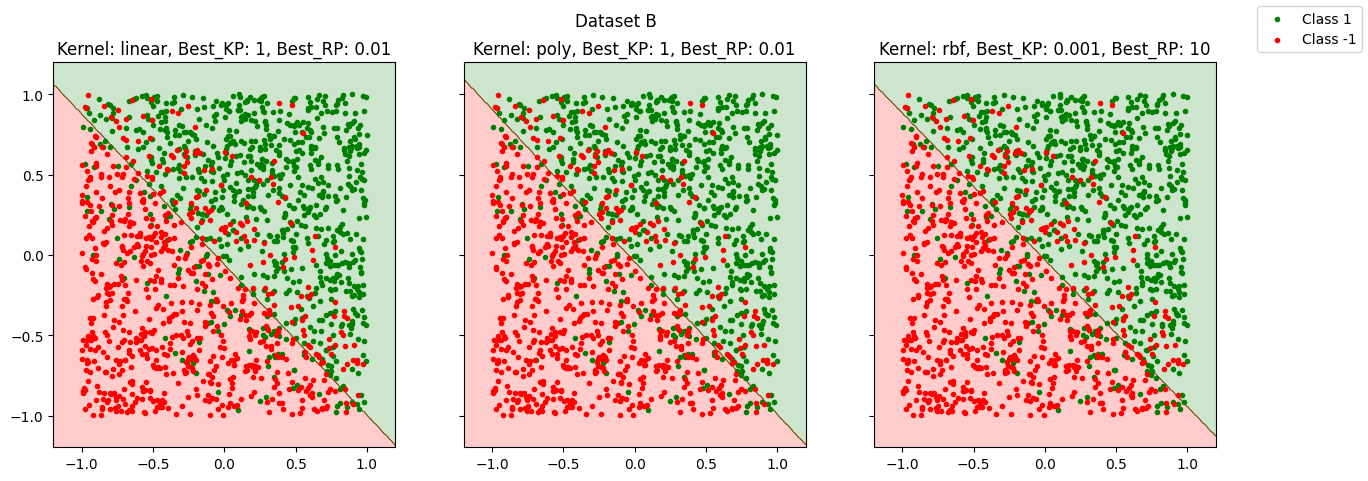

In [7]:
# Codewrite cell: Generate plots of learned classifier for all three kernel types, on dataset_A and datasset_B.
# Plots should give both the learned classifier and the train data. 
# Similar to  Bishop Figure 4.5 (with just two classes here.)
# Total number of plots = 3 * 2 = 6

kernels = ['linear', 'poly', 'rbf']

for a in ['A', 'B']:
    data = np.load('../../Data/dataset_{}.npz'.format(a))
    X_train, Y_train = data['arr_0'], data['arr_1']
    X_test, Y_test = data['arr_2'], data['arr_3']
    minX, maxX = np.min(X_train[:, 0]), np.max(X_train[:, 0])
    minY, maxY = np.min(X_train[:, 1]), np.max(X_train[:, 1])
    points = 500
    X, Y = np.meshgrid(np.linspace(minX-0.2, maxX+0.2, points), np.linspace(minY-0.2, maxY+0.2, points))
    X_plotter = np.c_[X.ravel(), Y.ravel()]

    fig, ax = plt.subplots(1, 3, sharey=True, figsize=(15, 5))
    line = [0, 0]
    for i, kernel in enumerate(kernels):
        clf = train_svm(X_train, Y_train, kernel=kernel, reg_param=best_reg_params[a][kernel], kernel_param=best_kernel_params[a][kernel])
        pred = predict_value(clf, X_plotter)
        pred[pred == 0] = 1
        Z = pred.reshape(X.shape)
        ax[i].contourf(X, Y, Z, colors=['red', 'green'], alpha=0.2)
        line[0] = ax[i].scatter(X_train[Y_train == 1, 0], X_train[Y_train == 1, 1], color='green', marker='.')
        line[1] = ax[i].scatter(X_train[Y_train == -1, 0], X_train[Y_train == -1, 1], color='red', marker='.')
        ax[i].set_title("Kernel: {}, Best_KP: {}, Best_RP: {}".format(kernel, best_kernel_params[a][kernel], best_reg_params[a][kernel]))
    fig.legend(line, ['Class 1', 'Class -1'], loc='upper right')
    fig.suptitle("Dataset {}".format(a))
    plt.show()

# 3. Decision Tree

Write code for learning decision tree below. Take as an argument a hyperparameter on what size node to stop splitting. Use a part of training set as validation set.

Write code for running in the cell after (You may be asked to demonstrate your code during the viva using this cell.)

In text cell after that report the following numbers you get by running appropriate code:

For all four data sets  report the best node size to stop splitting. Report the training and test zero-one error for those hyperparameters.

For datasets A and B, also illustrate the learned classifier. Do this in the last codeWrite cell for this question.

Important: Think about how you will represent a decision tree. (Possible soln: Store as a list of tuples containing node position, attribute to split, threshold, class to classifiy (if leaf node) )


In [8]:
# CodeWrite cell
# Write Decision tree classifier from scratch, 
# write only functions here (you may write extra functions here if you wish)

def entropy(p):
    """
    Computes entropy of a probability distribution
    """
    if(p == 0 or p == 1):
        return 0
    return -p * np.log2(p) - (1 - p) * np.log2(1 - p)

def find_entropy(X_left_count, X_right_count, X_left_pos, X_right_pos):
    """
    Computes entropy of a split using the counts of positive and negative 
    examples in the left and right side of the split
    """
    X_left_entropy, X_right_entropy = entropy(X_left_pos / X_left_count), entropy(X_right_pos / X_right_count)
    return (X_left_count * X_left_entropy + X_right_count * X_right_entropy) / (X_left_count + X_right_count)

def find_accuracy(X_left_count, X_right_count, X_left_pos, X_right_pos):
    """
    Computes accuracy of a split using the counts of positive and negative 
    examples in the left and right side of the split
    """
    X_left_neg, X_right_neg = X_left_count - X_left_pos, X_right_count - X_right_pos
    return max(X_left_pos + X_right_neg, X_left_neg + X_right_pos, X_left_pos + X_right_pos, X_left_neg + X_right_neg) / (X_left_count + X_right_count)

def find_best_attribute_threshold(X, Y, criterion):
    """
    Finds the best attribute and threshold to split based on the criterion
    """
    best_attribute, best_threshold = None, None
    best_accuracy, best_entropy = 0, np.inf

    for attribute in range(X.shape[1]):
        sorted_thresholds = np.sort(np.unique(X[:, attribute]))
        sorted_X, sorted_Y = np.sort(X[:, attribute]), Y[np.argsort(X[:, attribute])]
        X_left_count, X_right_count = 0, X.shape[0]
        X_left_pos, X_right_pos = 0, np.sum(sorted_Y == 1)

        for threshold in sorted_thresholds:
            while(X_left_count < X.shape[0] and sorted_X[X_left_count] <= threshold):
                if(sorted_Y[X_left_count] == 1):
                    X_left_pos, X_right_pos = X_left_pos + 1, X_right_pos - 1
                X_left_count, X_right_count = X_left_count + 1, X_right_count - 1

            if(criterion == 'entropy'):
                entropy = find_entropy(X_left_count, X_right_count, X_left_pos, X_right_pos)
                if(entropy < best_entropy):
                    best_entropy, best_attribute, best_threshold = entropy, attribute, threshold

            elif(criterion == 'accuracy'):
                accuracy = find_accuracy(X_left_count, X_right_count, X_left_pos, X_right_pos)
                if(accuracy > best_accuracy):
                    best_accuracy, best_attribute, best_threshold = accuracy, attribute, threshold
    return best_attribute, best_threshold

class Node:
    """
    Node class for the decision tree
    """
    def __init__(self, attribute, type, value, threshold):
        self.attribute = attribute
        self.type = type # 0: leaf, 1: internal
        self.value = value # if leaf, value is the class label, else None
        self.threshold = threshold # if internal, threshold is the threshold, else None
        self.left, self.right = None, None

    def split_node(self, X, Y, criterion, num_nodes_stop):
        """
        Splits the node into two children nodes based on the best attribute and threshold
        """
        if(X.shape[0] <= num_nodes_stop):
            self.type = 0
            self.value = np.sign(np.sum(Y)) if np.sum(Y) != 0 else 1
            return self
        
        pos_count = np.sum(Y == 1)
        if(pos_count == 0 or pos_count == Y.shape[0]):
            self.type = 0
            self.value = np.sign(np.sum(Y)) if np.sum(Y) != 0 else 1
            return self

        self.type = 1
        self.attribute, self.threshold = find_best_attribute_threshold(X, Y, criterion)
        X_left, X_right = X[X[:, self.attribute] <= self.threshold], X[X[:, self.attribute] > self.threshold]
        Y_left, Y_right = Y[X[:, self.attribute] <= self.threshold], Y[X[:, self.attribute] > self.threshold]

        if(X_left.shape == X.shape or X_right.shape == X.shape):
            self.type = 0
            self.value = np.sign(np.sum(Y)) if np.sum(Y) != 0 else 1
            return self

        node_left, node_right = Node(None, None, None, None), Node(None, None, None, None)
        self.left = node_left.split_node(X_left, Y_left, criterion, num_nodes_stop)
        self.right = node_right.split_node(X_right, Y_right, criterion, num_nodes_stop)
        return self

    def predict(self, X):
        """
        Predicts the class label for a given example matrix
        """
        if(self.type == 0):
            return self.value
        else:
            return self.left.predict(X) if X[self.attribute] <= self.threshold else self.right.predict(X)

def train_decision_tree(X, Y, num_nodes_stop=1, criterion='accuracy'):
    """ 
    Returns a decision tree trained on X and Y. 
    Stops splitting nodes when a node has hit a size of "num_nodes_stop" or lower.
    Split criterion can be either 'accuracy' or 'entropy'.
    Returns a tree (In whatever format that you find appropriate)
    """
    root = Node(None, None, None, None)
    return root.split_node(X, Y, criterion, num_nodes_stop)

def eval_decision_tree(tree, test_X):
    """ 
    Takes in a tree, and a bunch of instances X and 
    returns the tree predicted values at those instances.
    """
    return np.array([tree.predict(x) for x in test_X])

In [9]:
# CodeWrite cell
# Write code here for doing validation to find the best hyperparameters (i.e. num_nodes_stop)
# Also Generate the numbers that you report below. 
# Repeat with criterion set to entropy also.
# best_num_nodes is dict of dicts with dataset and criterion as keys and best num_nodes_stop as value

best_num_nodes = {'A': {}, 'B': {}, 'C': {}, 'D': {}}

for a in ['A', 'B', 'C', 'D']:
    data = np.load("../../Data/dataset_{}.npz".format(a))
    X_train, Y_train = data['arr_0'], data['arr_1']
    X_test, Y_test = data['arr_2'], data['arr_3']
    print('Dataset {}'.format(a))

    X_train_full, Y_train_full = X_train, Y_train
    rand_perm = np.random.permutation(X_train.shape[0])
    X_train, X_val = X_train[rand_perm[:int(0.8 * X_train.shape[0])]], X_train[rand_perm[int(0.8 * X_train.shape[0]):]]
    Y_train, Y_val = Y_train[rand_perm[:int(0.8 * Y_train.shape[0])]], Y_train[rand_perm[int(0.8 * Y_train.shape[0]):]]

    num_nodes_stops = np.array(range(40, 0, -1))
    criterions = ['accuracy', 'entropy']
    for criterion in criterions:
        best_accuracy, best_num_nodes_stop = 0, 0
        for num_nodes_stop in num_nodes_stops:
            tree = train_decision_tree(X_train, Y_train, num_nodes_stop, criterion)
            Y_pred = eval_decision_tree(tree, X_val)
            accuracy = np.sum(Y_pred == Y_val) / Y_val.shape[0]
            if(accuracy > best_accuracy):
                best_accuracy, best_num_nodes_stop = accuracy, num_nodes_stop
        print('Best val_accuracy = {} with criterion = {} and num_nodes_stop = {}'.format(best_accuracy, criterion, best_num_nodes_stop))
        best_num_nodes[a][criterion] = best_num_nodes_stop
        best_tree = train_decision_tree(X_train_full, Y_train_full, best_num_nodes_stop, criterion)
        test_pred = eval_decision_tree(best_tree, X_test)
        test_accuracy = np.sum(test_pred == Y_test) / Y_test.shape[0]
        train_pred = eval_decision_tree(best_tree, X_train_full)
        train_accuracy = np.sum(train_pred == Y_train_full) / Y_train_full.shape[0]
        print('Train accuracy = {}'.format(train_accuracy))
        print('Test accuracy = {}'.format(test_accuracy))
    print()

Dataset A
Best val_accuracy = 0.9433333333333334 with criterion = accuracy and num_nodes_stop = 6
Train accuracy = 0.9933333333333333
Test accuracy = 0.928
Best val_accuracy = 0.9966666666666667 with criterion = entropy and num_nodes_stop = 40
Train accuracy = 1.0
Test accuracy = 0.99

Dataset B
Best val_accuracy = 0.78 with criterion = accuracy and num_nodes_stop = 31
Train accuracy = 0.932
Test accuracy = 0.732
Best val_accuracy = 0.8133333333333334 with criterion = entropy and num_nodes_stop = 36
Train accuracy = 0.89
Test accuracy = 0.774

Dataset C
Best val_accuracy = 0.9 with criterion = accuracy and num_nodes_stop = 12
Train accuracy = 0.9326666666666666
Test accuracy = 0.8417508417508418
Best val_accuracy = 0.9433333333333334 with criterion = entropy and num_nodes_stop = 4
Train accuracy = 0.996
Test accuracy = 0.8922558922558923

Dataset D
Best val_accuracy = 0.9625 with criterion = accuracy and num_nodes_stop = 5
Train accuracy = 0.9875
Test accuracy = 0.893491124260355
Best 

TextWrite cell: Give your observations and the list of hyperparameter choices and train zero-one error  and test zero-one error, for all 4 datasets (2 real world and 2 synthetic).

### Observations

1. The entropy criterion performs better than the accuracy criterion for all the datasets.

2. The validation error is similar to the testing error for all the datasets. This shows that the model is not overfitting the data.

3. In the dataset A, the tree does not overfit with the entropy criterion and the accuracy is almost 100% for both the training and testing data.

4. In the dataset B, the tree overfits with accuracy criterion and the accuracy is almost 100% for the training data but only 75% for the testing data.

5. Entropy criterion gives trees with smaller depth. This is because the entropy criterion tries to split the data into two equal halves. This is not possible for all the datasets and thus the tree is not able to split the data into two equal halves. This is why the entropy criterion gives trees with smaller depth.

6. The values of the hyperparameter are checked in reverse from 40 to 1 to avoid overfitting.

7. The hyper-parameter for some cases are 40 which is good as the tree is not overfitting the data in entropy criterion.

### Best hyperparameters for each dataset
- Used 20 % of training data as validation set in random

- The validation set was chosen randomly from the training set each time so the results may vary slightly but the values will be similar.

| Dataset | Criterion | Best num_nodes_stop | Train Accuracy | Test Accuracy |
|:-------:|:--------------:|:-------------------:|:--------------:|:-------------:|
| A       | Accuracy       | 8                   | 0.991          | 0.926         |
| A       | Entropy        | 40                  | 1.0            | 0.99          |
| B       | Accuracy       | 7                   | 0.961          | 0.722         |
| B       | Entropy        | 40                  | 0.882          | 0.78          |
| C       | Accuracy       | 5                   | 0.933          | 0.841         |
| C       | Entropy        | 7                   | 0.993          | 0.889         |
| D       | Accuracy       | 6                   | 0.987          | 0.893         |
| D       | Entropy        | 24                  | 0.955          | 0.935         |

### Best Criterion and its parameters for each dataset

| Dataset | Best Criterion | num_nodes_stop |
|:-------:|:--------------:|:--------------:|
| A       | Entropy        | 40             |
| B       | Entropy        | 40             |
| C       | Entropy        | 7              |
| D       | Entropy        | 24             |

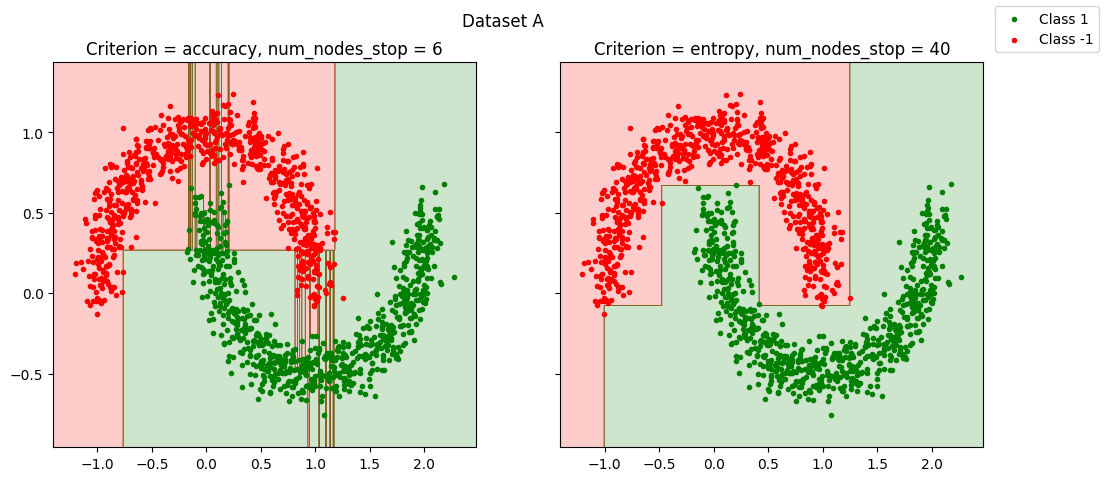

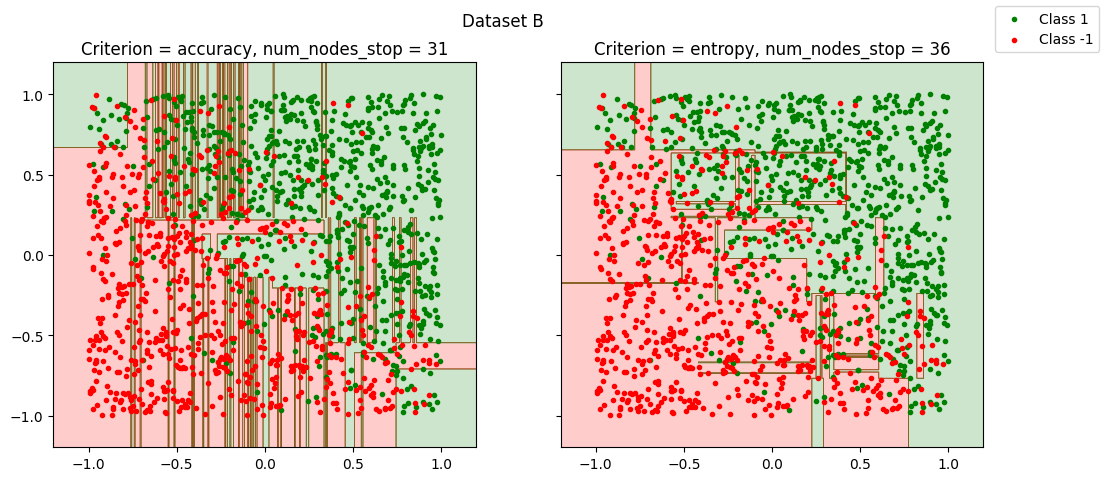

In [10]:
## Codewrite cell: Generate plots of learned decision tree classifier on dataset_A and datasset_B.
# Plots should give both the learned classifier and the train data. 
# Plots only required for the accuracy criterion.
# Similar to  Bishop Figure 4.5 (with just two classes here.)
# Total number of plots = 2 

# this cell needs to be run after the cell above as it uses the best_num_nodes dict

criterions = ['accuracy', 'entropy']

for a in ['A', 'B']:
    data = np.load('../../Data/dataset_{}.npz'.format(a))
    X_train, Y_train = data['arr_0'], data['arr_1']
    X_test, Y_test = data['arr_2'], data['arr_3']
    minX, maxX = np.min(X_train[:, 0]), np.max(X_train[:, 0])
    minY, maxY = np.min(X_train[:, 1]), np.max(X_train[:, 1])
    points = 500
    X, Y = np.meshgrid(np.linspace(minX-0.2, maxX+0.2, points), np.linspace(minY-0.2, maxY+0.2, points))
    X_plotter = np.c_[X.ravel(), Y.ravel()]

    fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12, 5))
    line = [0, 0]
    for i, criterion in enumerate(criterions):
        tree = train_decision_tree(X_train, Y_train, best_num_nodes[a][criterion], criterion)
        Y_pred = eval_decision_tree(tree, X_plotter)
        Y_pred[Y_pred == 0] = 1
        Z = Y_pred.reshape(X.shape)
        ax[i].contourf(X, Y, Z, colors=['red', 'green'], alpha=0.2)
        line[0] = ax[i].scatter(X_train[Y_train == 1, 0], X_train[Y_train == 1, 1], color='green', marker='.')
        line[1] = ax[i].scatter(X_train[Y_train == -1, 0], X_train[Y_train == -1, 1], color='red', marker='.')
        ax[i].set_title('Criterion = {}, num_nodes_stop = {}'.format(criterion, best_num_nodes[a][criterion]))
    fig.legend(line, ['Class 1', 'Class -1'], loc='upper right')
    fig.suptitle('Dataset {}'.format(a))
    plt.show()

# 4 Random Forest classifier

Write code for learning RandomForests below. Fix the following hyper parameters: (Fraction of data to learn tree=0.5, Fraction of number of features chosen in each node=0.5, num_nodes_stop=1).  Choose the number of trees to add in the forest by using a validation set. You may use a slightly modified version of the decision tree code you had written earlier.

Write code for running in the cell after the nest. (You may be asked to demonstrate your code during the viva using this cell.) 

In text cell after that report the following numbers you get by running appropriate code:

For all 4 data sets (A,B,C,D)  report the best number of trees found. Report the training and test zero-one error for those hyperparameters.

For the synthetic classification datasets (datasets A and B) in 2-dimensions, also illustrate the learned classifier for each kernel setting. Do this in the last codeWrite cell for this question.

In [11]:
# CodeWrite cell
# Write Random Forest classifier. 

def entropy(p):
    """
    Computes entropy of a probability distribution
    """
    if(p == 0 or p == 1):
        return 0
    return -p * np.log2(p) - (1 - p) * np.log2(1 - p)

def find_entropy(X_left_count, X_right_count, X_left_pos, X_right_pos):
    """
    Computes entropy of a split using the counts of positive and negative 
    examples in the left and right side of the split
    """
    X_left_entropy = entropy(X_left_pos / X_left_count)
    X_right_entropy = entropy(X_right_pos / X_right_count)
    tot_entropy = (X_left_count * X_left_entropy + X_right_count * X_right_entropy) / (X_left_count + X_right_count)
    return tot_entropy

def find_accuracy(X_left_count, X_right_count, X_left_pos, X_right_pos):
    """
    Computes accuracy of a split using the counts of positive and negative 
    examples in the left and right side of the split
    """
    X_left_neg = (X_left_count - X_left_pos)
    X_right_neg = (X_right_count - X_right_pos)
    total = X_left_count + X_right_count
    return max(X_left_pos + X_right_neg, X_left_neg + X_right_pos, X_left_pos + X_right_pos, X_left_neg + X_right_neg) / total

def find_best_attribute_threshold(X, Y, criterion, b=0.5):
    """
    Finds the best attribute and threshold to split based on the criterion
    """
    best_attribute, best_threshold = None, None
    best_accuracy, best_entropy = 0, np.inf
    
    attributes = np.random.choice(X.shape[1], int(b * X.shape[1]), replace=False)

    for attribute in attributes:
        sorted_thresholds = np.sort(np.unique(X[:, attribute]))
        sorted_X, sorted_Y = np.sort(X[:, attribute]), Y[np.argsort(X[:, attribute])]
        X_left_count, X_right_count = 0, X.shape[0]
        X_left_pos, X_right_pos = 0, np.sum(sorted_Y == 1)

        for threshold in sorted_thresholds:
            while(X_left_count < X.shape[0] and sorted_X[X_left_count] <= threshold):
                if(sorted_Y[X_left_count] == 1):
                    X_left_pos, X_right_pos = X_left_pos + 1, X_right_pos - 1
                X_left_count, X_right_count = X_left_count + 1, X_right_count - 1

            if(criterion == 'entropy'):
                entropy = find_entropy(X_left_count, X_right_count, X_left_pos, X_right_pos)
                if(entropy < best_entropy):
                    best_entropy, best_attribute, best_threshold = entropy, attribute, threshold

            elif(criterion == 'accuracy'):
                accuracy = find_accuracy(X_left_count, X_right_count, X_left_pos, X_right_pos)
                if(accuracy > best_accuracy):
                    best_accuracy, best_attribute, best_threshold = accuracy, attribute, threshold
    return best_attribute, best_threshold

class Node:
    """
    Node class for the decision tree
    """
    def __init__(self, attribute, type, value, threshold):
        self.attribute = attribute
        self.type = type # 0: leaf, 1: internal
        self.value = value # if leaf, value is the class label, else None
        self.threshold = threshold # if internal, threshold is the threshold, else None
        self.left, self.right = None, None

    def split_node(self, X, Y, criterion, num_nodes_stop, b=0.5):
        """
        Splits the node into two children nodes based on the best attribute and threshold
        """
        if(X.shape[0] <= num_nodes_stop):
            self.type = 0
            self.value = np.sign(np.sum(Y)) if np.sum(Y) != 0 else 1
            return self
        
        pos_count = np.sum(Y == 1)
        if(pos_count == 0 or pos_count == Y.shape[0]):
            self.type = 0
            self.value = np.sign(np.sum(Y)) if np.sum(Y) != 0 else 1
            return self

        self.type = 1
        self.attribute, self.threshold = find_best_attribute_threshold(X, Y, criterion, b)
        X_left, X_right = X[X[:, self.attribute] <= self.threshold], X[X[:, self.attribute] > self.threshold]
        Y_left, Y_right = Y[X[:, self.attribute] <= self.threshold], Y[X[:, self.attribute] > self.threshold]

        if(X_left.shape == X.shape or X_right.shape == X.shape):
            self.type = 0
            self.value = np.sign(np.sum(Y)) if np.sum(Y) != 0 else 1
            return self

        node_left, node_right = Node(None, None, None, None), Node(None, None, None, None)
        self.left = node_left.split_node(X_left, Y_left, criterion, num_nodes_stop, b)
        self.right = node_right.split_node(X_right, Y_right, criterion, num_nodes_stop, b)
        return self

    def predict(self, X):
        """
        Predicts the class label for a given example matrix
        """
        if(self.type == 0):
            return self.value
        else:
            return self.left.predict(X) if X[self.attribute] <= self.threshold else self.right.predict(X)

def train_decision_tree(X, Y, num_nodes_stop=1, criterion='accuracy', b=0.5):
    """ 
    Returns a decision tree trained on X and Y. 
    Stops splitting nodes when a node has hit a size of "num_nodes_stop" or lower.
    Split criterion can be either 'accuracy' or 'entropy'.
    Returns a tree (In whatever format that you find appropriate)
    """
    root = Node(None, None, None, None)
    return root.split_node(X, Y, criterion, num_nodes_stop, b)

def eval_decision_tree(tree, test_X):
    """ 
    Takes in a tree, and a bunch of instances X and 
    returns the tree predicted values at those instances.
    """
    return np.array([tree.predict(x) for x in test_X])

class Forest:
    def __init__(self):
        self.trees = []
    
    def add_tree(self, tree):
        self.trees.append(tree)
    
    def predict_values(self, X):
        predictions = np.array([eval_decision_tree(tree, X) for tree in self.trees])
        return np.sign(np.sum(predictions, axis=0))

def resample(X, Y, percent):
    """
    Returns a resampled dataset of size a from the given dataset
    """
    indices = np.random.choice(X.shape[0], int(percent * X.shape[0]), replace=True)
    return X[indices], Y[indices]

def train_random_forest(X, Y, num_trees=10, num_nodes_stop=1, criterion='accuracy', a=0.5, b=0.5):
    """ 
    Returns a random forest trained on X and Y. 
    Trains num_trees.
    Stops splitting nodes in each tree when a node has hit a size of "num_nodes_stop" or lower.
    Split criterion can be either 'accuracy' or 'entropy'.
    Fraction of data used per tree = a
    Fraction of features used in each node = b
    Returns a random forest (In whatever format that you find appropriate)
    """
    forest = Forest()
    for _ in range(num_trees):
        X_train, Y_train = resample(X, Y, a)
        tree = train_decision_tree(X_train, Y_train, num_nodes_stop, criterion, b)
        forest.add_tree(tree)
    return forest

def eval_random_forest(random_forest, test_X):
    """ 
    Takes in a  random forest object (however you want to store it), and a bunch of instances X and 
    returns the tree predicted values at those instances.
    """
    return random_forest.predict_values(test_X)

In [12]:
# CodeWrite cell
# Write code for choosing the best hyperparameters (num_trees, num_nodes_stop)
# Write code here for generating the numbers that you report below.
# Repeat above for criterion set to entropy also.

num_trees = [1, 5, 10, 20, 50, 100, 200, 250, 500]
criterions = ['accuracy', 'entropy']

best_num_trees = {'A':{}, 'B':{}, 'C':{}, 'D':{}}

def find_best_hyperparameters(X, Y, criterion, num_nodes_stop=1, a=0.5, b=0.5):
    """
    Returns the best hyperparameters for the given criterion
    """
    best_num_tree = None
    best_accuracy = 0
    rand_perm = np.random.permutation(X.shape[0])
    X_train, Y_train = X[rand_perm[:int(0.8 * X.shape[0])]], Y[rand_perm[:int(0.8 * X.shape[0])]]
    X_val, Y_val = X[rand_perm[int(0.8 * X.shape[0]):]], Y[rand_perm[int(0.8 * X.shape[0]):]]
    for num_tree in num_trees:
        forest = train_random_forest(X_train, Y_train, num_tree, num_nodes_stop, criterion, a, b)
        predictions = eval_random_forest(forest, X_val)
        accuracy = np.sum(predictions == Y_val) / Y_val.shape[0]
        if(accuracy > best_accuracy):
            best_accuracy, best_num_tree = accuracy, num_tree
    return best_num_tree, best_accuracy

for a in ['A', 'B', 'C', 'D']:
    print(f"Dataset {a}")
    data = np.load('../../Data/dataset_{}.npz'.format(a))
    X_train, Y_train, X_test, Y_test = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
    for criterion in criterions:
        print(f"Criterion: {criterion}")
        num_tree, accuracy = find_best_hyperparameters(X_train, Y_train, criterion, num_nodes_stop=1, a=0.5, b=0.5)
        best_num_trees[a][criterion] = num_tree
        print(f"Best number of trees: {num_tree}")
        print(f"Best Validation Accuracy: {accuracy}")
        forest = train_random_forest(X_train, Y_train, num_tree, 1, criterion)
        predictions = eval_random_forest(forest, X_test)
        predictions_train = eval_random_forest(forest, X_train)
        print(f"Train Accuracy: {np.sum(predictions_train == Y_train) / Y_train.shape[0]}")
        print(f"Test Accuracy: {np.sum(predictions == Y_test) / Y_test.shape[0]}")
        print()

Dataset A
Criterion: accuracy
Best number of trees: 10
Best Validation Accuracy: 0.9666666666666667
Train Accuracy: 0.9886666666666667
Test Accuracy: 0.95

Criterion: entropy
Best number of trees: 5
Best Validation Accuracy: 0.9966666666666667
Train Accuracy: 0.9993333333333333
Test Accuracy: 0.988

Dataset B
Criterion: accuracy
Best number of trees: 50
Best Validation Accuracy: 0.76
Train Accuracy: 0.9433333333333334
Test Accuracy: 0.786

Criterion: entropy
Best number of trees: 5
Best Validation Accuracy: 0.8133333333333334
Train Accuracy: 0.914
Test Accuracy: 0.772

Dataset C
Criterion: accuracy
Best number of trees: 50
Best Validation Accuracy: 0.9433333333333334
Train Accuracy: 0.974
Test Accuracy: 0.9057239057239057

Criterion: entropy
Best number of trees: 250
Best Validation Accuracy: 0.9766666666666667
Train Accuracy: 0.998
Test Accuracy: 0.9629629629629629

Dataset D
Criterion: accuracy
Best number of trees: 10
Best Validation Accuracy: 0.9625
Train Accuracy: 0.9725
Test Accu

TextWrite cell: Give your observations and the list of hyperparameter choices and train zero-one error  and test zero-one error, for all 4 datasets (2 real world and 2 synthetic).  

### Observations

1. The entropy criterion performs better than the accuracy criterion for all the datasets.

2. The random forest classifier performs better than the decision tree classifier for all the datasets.

3. The accuracy changes are considerable for all the datasets except the second.

4. The accuracy criterion tends to overfit the data for all the datasets.

5. The values given in the table may vary with each run as the training and validation sets are chosen at random each time but the accuracies will be similar.

6. The entropy criterion gives trees with smaller depth. This is because the entropy criterion tries to split the data into two equal halves. This is not possible for all the datasets and thus the tree is not able to split the data into two equal halves. This is why the entropy criterion gives trees with smaller depth.

### Best hyperparameters for each dataset
- Used 20 % of training data as validation set in random

- The validation set was chosen randomly from the training set each time so the results may vary slightly but the values will be similar.

- The num_nodes_stop was set to 1 for all the datasets to overfit in each tree and then the trees were combined to get a better accuracy.

- The fraction of data to learn tree was set to 0.5 for all the datasets and was chosen at random with replacement.

- The fraction of number of features chosen in each node was set to 0.5 for all the datasets and was chosen at random with replacement.

| Dataset | Criterion | Best num_trees | Train Accuracy | Test Accuracy |
|:-------:|:--------------:|:--------------:|:--------------:|:-------------:|
| A       | Accuracy       | 100            | 0.99           | 0.966         |
| A       | Entropy        | 200            | 0.9986         | 0.99          |
| B       | Accuracy       | 250            | 0.9453         | 0.784         |
| B       | Entropy        | 50             | 0.9466         | 0.768         |
| C       | Accuracy       | 5              | 0.9653         | 0.8585        |
| C       | Entropy        | 20             | 0.994          | 0.9562        |
| D       | Accuracy       | 50             | 0.99           | 0.9349        |
| D       | Entropy        | 200            | 0.9925         | 0.9644        |

### Best Criterion and its parameters for each dataset

| Dataset | Best Criterion | num_trees |
|:-------:|:--------------:|:---------:|
| A       | Entropy        | 200       |
| B       | Entropy        | 50        |
| C       | Entropy        | 20        |
| D       | Entropy        | 200       |

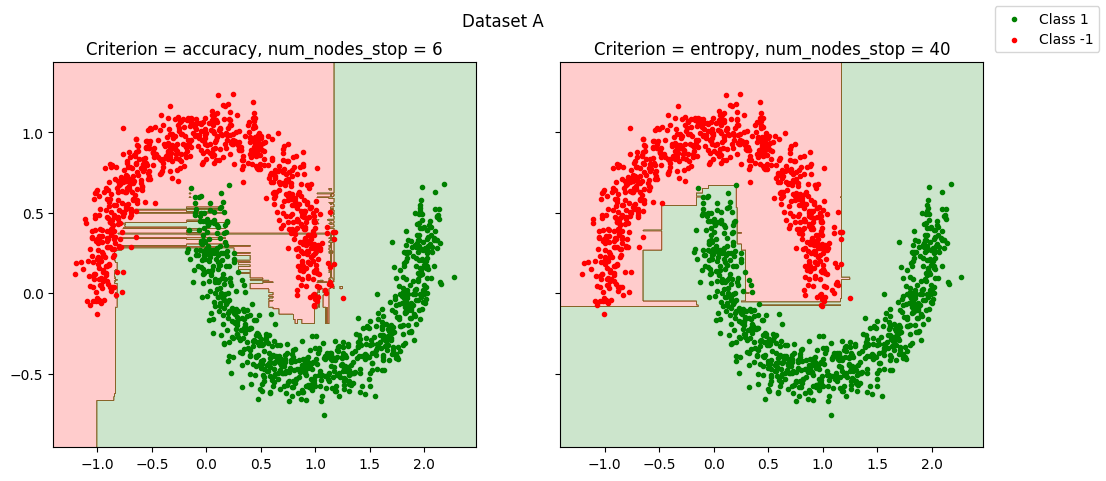

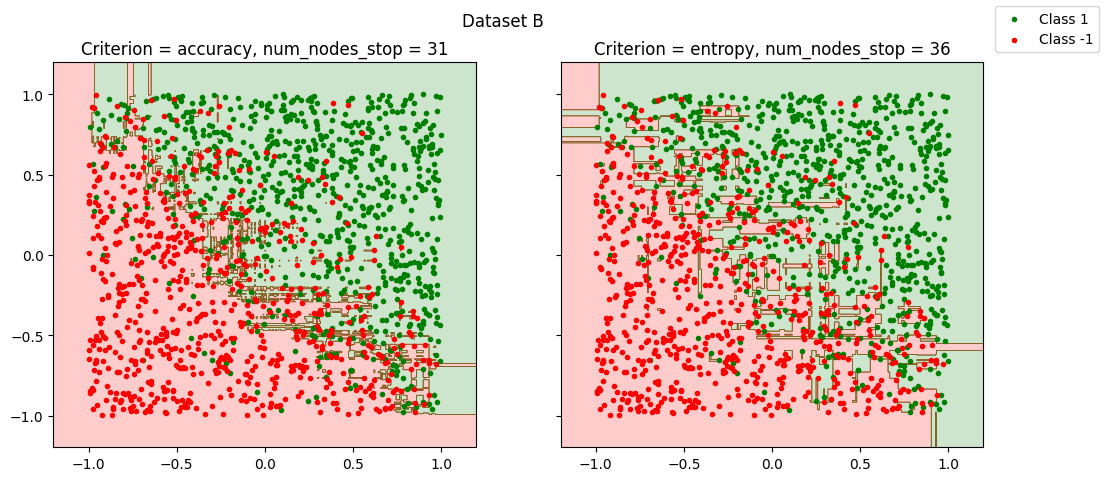

In [13]:
## Codewrite cell: Generate plots of learned Random Forest classifier on dataset_A and datasset_B.
# Plots should give both the learned classifier and the train data. 
# Plots required only for the accuracy criterion.
# Similar to  Bishop Figure 4.5 (with just two classes here.)
# Total number of plots = 2 

criterions = ['accuracy', 'entropy']

for a in ['A', 'B']:
    data = np.load('../../Data/dataset_{}.npz'.format(a))
    X_train, Y_train = data['arr_0'], data['arr_1']
    X_test, Y_test = data['arr_2'], data['arr_3']
    minX, maxX = np.min(X_train[:, 0]), np.max(X_train[:, 0])
    minY, maxY = np.min(X_train[:, 1]), np.max(X_train[:, 1])
    points = 500
    X, Y = np.meshgrid(np.linspace(minX-0.2, maxX+0.2, points), np.linspace(minY-0.2, maxY+0.2, points))
    X_plotter = np.c_[X.ravel(), Y.ravel()]

    fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12, 5))
    line = [0, 0]
    for i, criterion in enumerate(criterions):
        forest = train_random_forest(X_train, Y_train, best_num_trees[a][criterion], 1, criterion)
        Y_pred = eval_random_forest(forest, X_plotter)
        Y_pred[Y_pred == 0] = 1
        Z = Y_pred.reshape(X.shape)
        ax[i].contourf(X, Y, Z, colors=['red', 'green'], alpha=0.2)
        line[0] = ax[i].scatter(X_train[Y_train == 1, 0], X_train[Y_train == 1, 1], color='green', marker='.')
        line[1] = ax[i].scatter(X_train[Y_train == -1, 0], X_train[Y_train == -1, 1], color='red', marker='.')
        ax[i].set_title('Criterion = {}, num_nodes_stop = {}'.format(criterion, best_num_nodes[a][criterion]))
    fig.legend(line, ['Class 1', 'Class -1'], loc='upper right')
    fig.suptitle('Dataset {}'.format(a))
    plt.show()
        

# 5 AdaBoost

Write code for learning using AdaBoost below. Use 3 different weak learners below. (You may reuse code written above)

1. 1 node decision tree 
2. Decision tree of fixed depth = 3 (Root, child, grand child)
3. Decision tree of fixed depth = 7 (Root, child, grand child, ..., great^4 grand child)

Run for 50 iterations. You may use the accuracy split criterion for all the three weak learners.

Write code for running in the next cell. (You may be asked to demonstrate your code during the viva using this cell.) 

In text cell after that report the following numbers you get by running appropriate code:

For all 4 data sets (A,B,C,D)  plot the train and test accuracy vs iterations. A total of 12 plots is expected. 4 datasets * 3 weak learners. Each plot should contain two curves, train and test error.  

For the synthetic classification datasets (datasets A and B) in 2-dimensions, also illustrate the learned classifier for each weak learner setting. A total of 6 contourf style plots are expected here. Do this in the last codeWrite cell for this question.

Summarise your observations in the last textwrite cell.

In [14]:
# Codewrite cell
# Write code to run here (no plotting)

def find_accuracy(X_left_weight, X_right_weight, X_left_pos, X_right_pos, X_left_neg, X_right_neg):
    """
    Computes accuracy of a split using the weights of positive and negative 
    examples in the left and right side of the split
    """
    return max(X_left_pos + X_right_neg, X_left_neg + X_right_pos, X_left_pos + X_right_pos, X_left_neg + X_right_neg) / (X_left_weight + X_right_weight)

def find_best_attribute_threshold(X, Y, weights):
    """
    Finds the best attribute and threshold to split
    """
    best_attribute, best_threshold = None, None
    best_accuracy = 0

    for attribute in range(X.shape[1]):
        sorted_thresholds = np.sort(np.unique(X[:, attribute]))
        sorted_X, sorted_Y, sorted_weights = np.sort(X[:, attribute]), Y[np.argsort(X[:, attribute])], weights[np.argsort(X[:, attribute])]
        X_left_count, X_right_count = 0, sorted_X.shape[0]
        X_left_weight, X_right_weight = 0, np.sum(sorted_weights)
        X_left_pos, X_right_pos = 0, np.sum(sorted_weights[sorted_Y == 1])
        X_left_neg, X_right_neg = 0, np.sum(sorted_weights[sorted_Y == -1])

        for threshold in sorted_thresholds:
            while(X_left_count < X.shape[0] and sorted_X[X_left_count] <= threshold):
                if(sorted_Y[X_left_count] == 1):
                    X_left_pos, X_right_pos = X_left_pos + sorted_weights[X_left_count], X_right_pos - sorted_weights[X_left_count]
                else:
                    X_left_neg, X_right_neg = X_left_neg + sorted_weights[X_left_count], X_right_neg - sorted_weights[X_left_count]
                X_left_weight, X_right_weight = X_left_weight + sorted_weights[X_left_count], X_right_weight - sorted_weights[X_left_count]
                X_left_count, X_right_count = X_left_count + 1, X_right_count - 1

            accuracy = find_accuracy(X_left_weight, X_right_weight, X_left_pos, X_right_pos, X_left_neg, X_right_neg)
            if(accuracy > best_accuracy):
                best_accuracy, best_attribute, best_threshold = accuracy, attribute, threshold
    return best_attribute, best_threshold

class Node:
    """
    Node class for the decision tree
    """
    def __init__(self, attribute, type, value, threshold):
        self.attribute = attribute
        self.type = type # 0: leaf, 1: internal
        self.value = value # if leaf, value is the class label, else None
        self.threshold = threshold # if internal, threshold is the threshold, else None
        self.left, self.right = None, None

    def split_node(self, X, Y, weights, max_depth, num_nodes_stop):
        """
        Splits the node into two children nodes based on the best attribute and threshold
        """
        if(X.shape[0] <= num_nodes_stop or max_depth <= 0):
            self.type = 0
            self.value = 1 if np.sum(weights[Y == 1]) >= np.sum(weights[Y == -1]) else -1
            return self
        
        pos_count = np.sum(Y == 1)
        if(pos_count == 0 or pos_count == Y.shape[0]):
            self.type = 0
            self.value = np.sign(np.sum(Y)) if np.sum(Y) != 0 else 1
            return self

        self.type = 1
        self.attribute, self.threshold = find_best_attribute_threshold(X, Y, weights)
        X_left, X_right = X[X[:, self.attribute] <= self.threshold], X[X[:, self.attribute] > self.threshold]
        Y_left, Y_right = Y[X[:, self.attribute] <= self.threshold], Y[X[:, self.attribute] > self.threshold]
        weights_left, weights_right = weights[X[:, self.attribute] <= self.threshold], weights[X[:, self.attribute] > self.threshold]

        if(X_left.shape == X.shape or X_right.shape == X.shape):
            self.type = 0
            self.value = 1 if np.sum(weights[Y == 1]) > np.sum(weights[Y == -1]) else -1
            return self

        node_left, node_right = Node(None, None, None, None), Node(None, None, None, None)
        self.left = node_left.split_node(X_left, Y_left, weights_left, num_nodes_stop, max_depth - 1)
        self.right = node_right.split_node(X_right, Y_right, weights_right, num_nodes_stop, max_depth - 1)
        return self

    def predict(self, X):
        """
        Predicts the class label for a given example matrix
        """
        if(self.type == 0):
            return self.value
        else:
            return self.left.predict(X) if X[self.attribute] <= self.threshold else self.right.predict(X)

def train_decision_tree(X, Y, weights, max_depth, num_nodes_stop):
    """ 
    Returns a decision tree trained on X and Y. 
    Stops splitting nodes when a node has hit a size of "num_nodes_stop" or lower.
    Split criterion can be either 'accuracy' or 'entropy'.
    Returns a tree (In whatever format that you find appropriate)
    """
    root = Node(None, None, None, None)
    return root.split_node(X, Y, weights, max_depth, num_nodes_stop)

def eval_decision_tree(tree, test_X):
    """ 
    Takes in a tree, and a bunch of instances X and 
    returns the tree predicted values at those instances.
    """
    return np.array([tree.predict(x) for x in test_X])

def Adaboost_train(X_train, Y_train, max_depth, num_iter, num_nodes_stop):
    """
    Trains a decision tree using Adaboost
    """
    trees, betas, train_accuracies, test_accuracies = [], [], [], []
    weights = np.ones(X_train.shape[0])
    for _ in range(num_iter):
        tree = train_decision_tree(X_train, Y_train, weights, max_depth, num_nodes_stop)
        predictions = eval_decision_tree(tree, X_train)
        trees = trees + [tree]
        error = np.sum(weights[predictions != Y_train]) / np.sum(weights)
        beta = (1-error)/error
        betas = betas + [beta]
        predictions_train = Adaboost_eval(trees, betas, X_train)
        train_accuracy = np.sum(predictions_train == Y_train) / Y_train.shape[0]
        predictions_test = Adaboost_eval(trees, betas, X_test)
        test_accuracy = np.sum(predictions_test == Y_test) / Y_test.shape[0]
        weights = weights * np.power(beta, predictions != Y_train)
        train_accuracies = train_accuracies + [train_accuracy]
        test_accuracies = test_accuracies + [test_accuracy]
    return trees, betas, train_accuracies, test_accuracies

def Adaboost_eval(trees, betas, X_test):
    """
    Evaluates the Adaboost model on the test data
    """
    Y_pred = np.zeros(X_test.shape[0])
    for i in range(len(trees)):
        Y_pred += np.log2(betas[i]) * eval_decision_tree(trees[i], X_test)
    return np.sign(Y_pred)

Dataset:  A
Max depth:  1 Train accuracy:  1.0 Test accuracy:  0.988
Max depth:  3 Train accuracy:  1.0 Test accuracy:  0.988
Max depth:  7 Train accuracy:  1.0 Test accuracy:  0.988


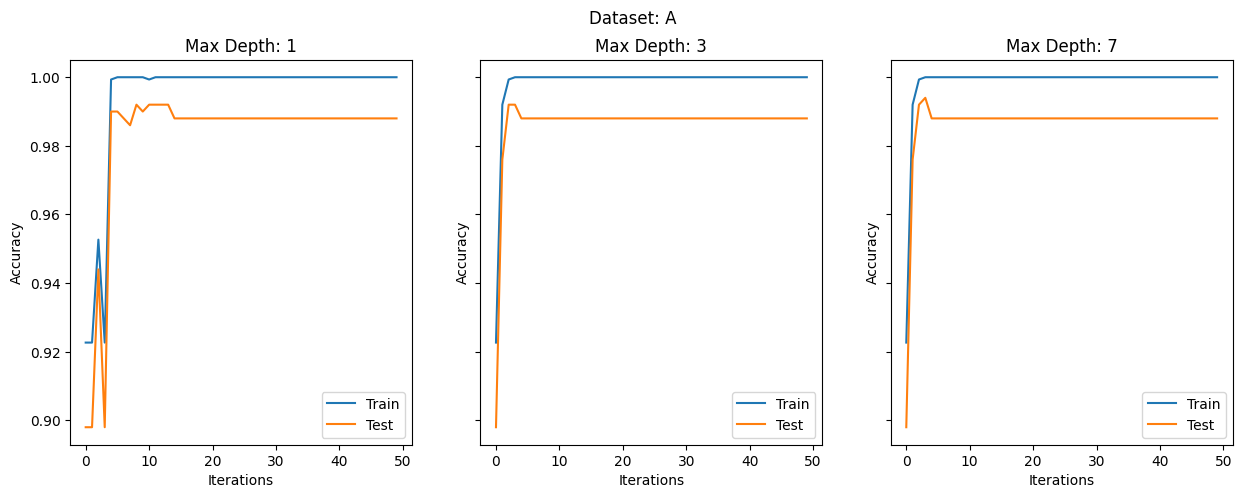

Dataset:  B
Max depth:  1 Train accuracy:  0.8553333333333333 Test accuracy:  0.794
Max depth:  3 Train accuracy:  0.9466666666666667 Test accuracy:  0.772
Max depth:  7 Train accuracy:  0.992 Test accuracy:  0.752


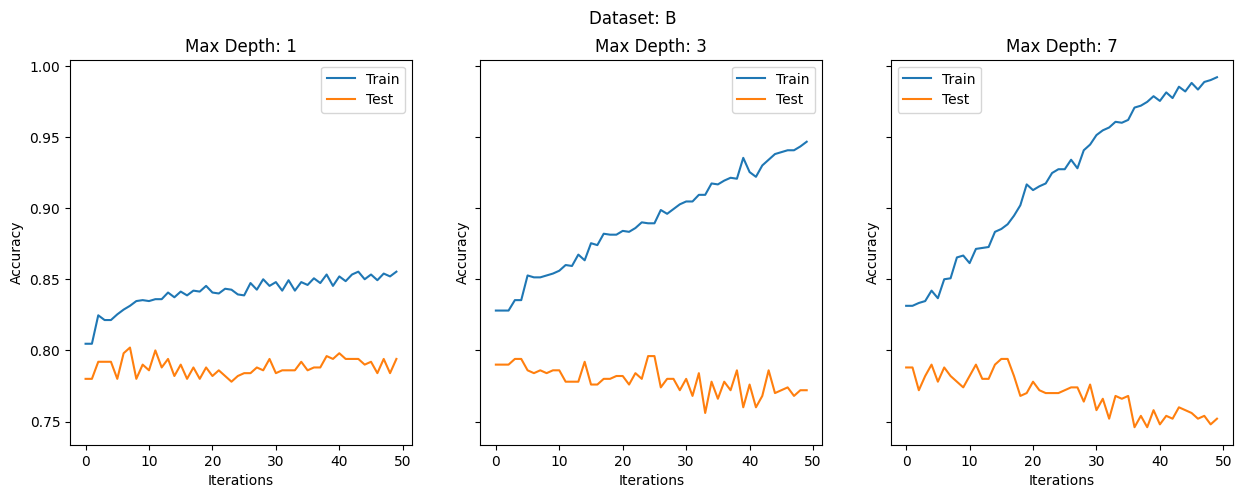

Dataset:  C
Max depth:  1 Train accuracy:  1.0 Test accuracy:  0.9528619528619529
Max depth:  3 Train accuracy:  1.0 Test accuracy:  0.9595959595959596
Max depth:  7 Train accuracy:  1.0 Test accuracy:  0.9461279461279462


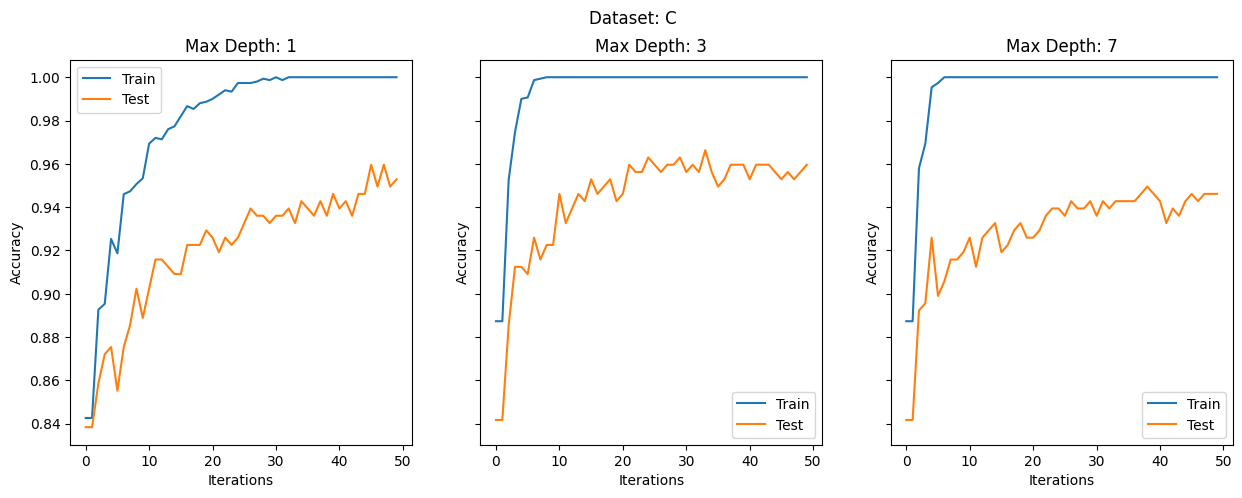

Dataset:  D
Max depth:  1 Train accuracy:  1.0 Test accuracy:  0.9763313609467456
Max depth:  3 Train accuracy:  1.0 Test accuracy:  0.9408284023668639
Max depth:  7 Train accuracy:  1.0 Test accuracy:  0.9585798816568047


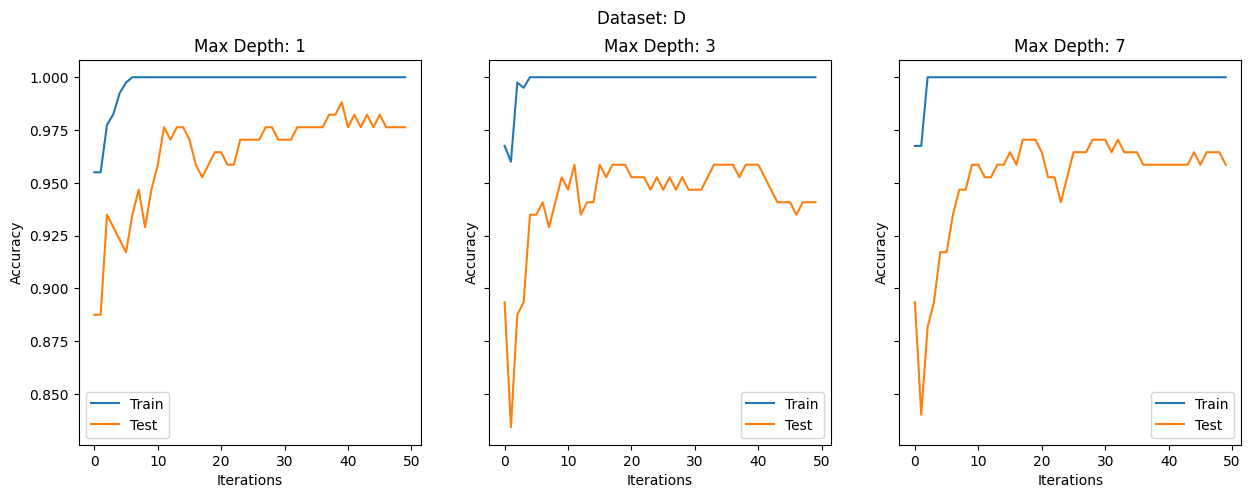

In [15]:
# Codewrite cell 
# Plots for iteration vs error here

max_depths = [1, 3, 7]

for a in ['A', 'B', 'C', 'D']:
    print("Dataset: ", a)
    data = np.load('../../Data/dataset_{}.npz'.format(a))
    X_train, Y_train, X_test, Y_test = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
    fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
    for i, max_depth in enumerate(max_depths):
        trees, betas, train_accuracies, test_accuracies = Adaboost_train(X_train, Y_train, max_depth, 50, int(0.1 * X_train.shape[0]))
        pred_train = Adaboost_eval(trees, betas, X_train)
        pred_test = Adaboost_eval(trees, betas, X_test)
        train_accuracy = np.sum(pred_train == Y_train) / Y_train.shape[0]
        test_accuracy = np.sum(pred_test == Y_test) / Y_test.shape[0]
        print("Max depth: ", max_depth, end=" ")
        print("Train accuracy: ", train_accuracy, end=" ")
        print("Test accuracy: ", test_accuracy)
        ax[i].plot(train_accuracies, label='Train')
        ax[i].plot(test_accuracies, label='Test')
        ax[i].set_xlabel('Iterations')
        ax[i].set_ylabel('Accuracy')
        ax[i].set_title("Max Depth: {}".format(max_depth))
        ax[i].legend(loc='best')
    fig.suptitle("Dataset: {}".format(a))
    plt.show()

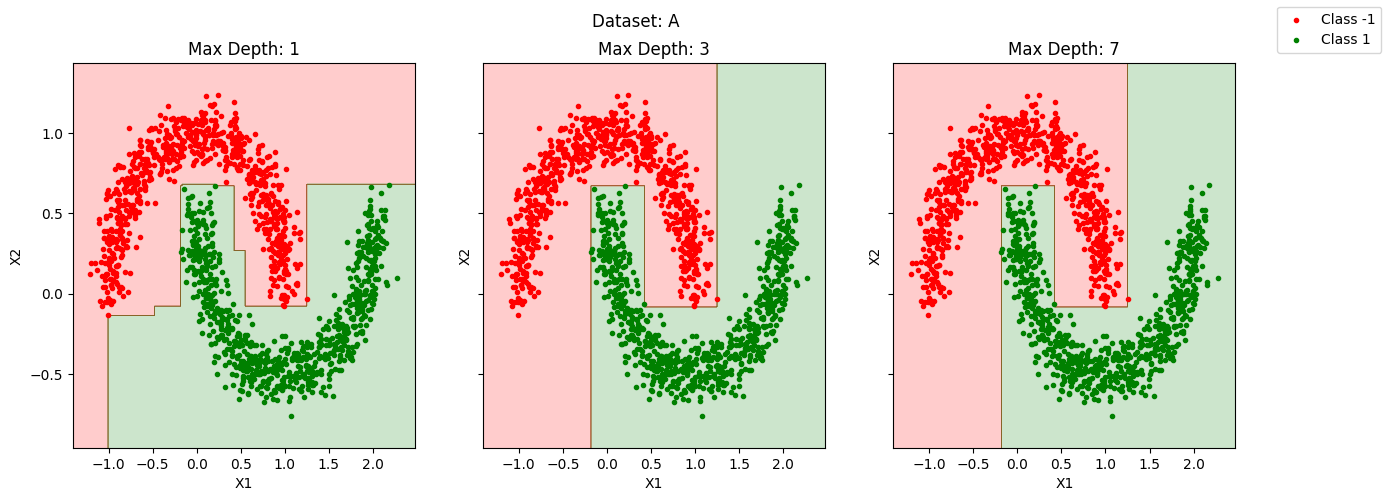

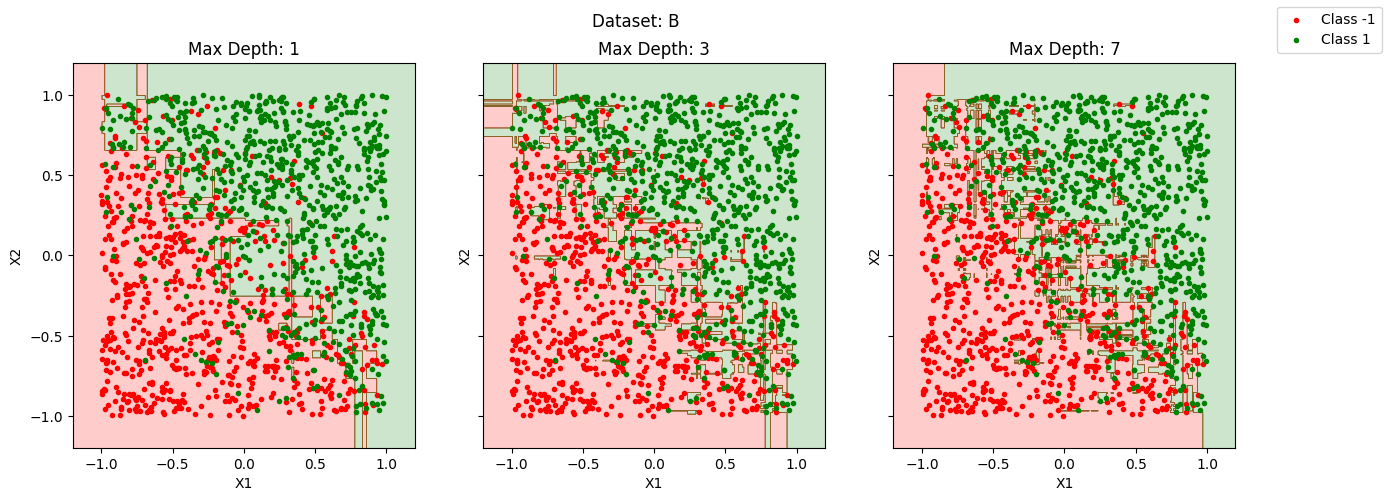

In [16]:
# Codewrite cell 
# Plots for illustrating the classifier here

max_depths = [1, 3, 7]

for a in ['A', 'B']:
    data = np.load('../../Data/dataset_{}.npz'.format(a))
    X_train, Y_train, X_test, Y_test = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
    fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
    minX, maxX = np.min(X_train[:, 0]), np.max(X_train[:, 0])
    minY, maxY = np.min(X_train[:, 1]), np.max(X_train[:, 1])
    points = 500
    X, Y = np.meshgrid(np.linspace(minX - 0.2, maxX + 0.2, points), np.linspace(minY - 0.2, maxY + 0.2, points))
    line = [0, 0]
    for i, max_depth in enumerate(max_depths):
        trees, betas, train_accuracies, test_accuracies = Adaboost_train(X_train, Y_train, max_depth, 50, int(0.1 * X_train.shape[0]))
        Z = Adaboost_eval(trees, betas, np.c_[X.ravel(), Y.ravel()])
        Z = Z.reshape(X.shape)
        ax[i].contourf(X, Y, Z, colors=['red', 'green'], alpha=0.2)
        line[0] = ax[i].scatter(X_train[Y_train == -1, 0], X_train[Y_train == -1, 1], color='red', label='Class -1', marker='.')
        line[1] = ax[i].scatter(X_train[Y_train == 1, 0], X_train[Y_train == 1, 1], color='green', label='Class 1', marker='.')
        ax[i].set_xlabel('X1')
        ax[i].set_ylabel('X2')
        ax[i].set_title("Max Depth: {}".format(max_depth))
    fig.suptitle("Dataset: {}".format(a))
    fig.legend(line, ['Class -1', 'Class 1'], loc='upper right')
    plt.show()

Textwrite cell:

### Observations

1. The higher depths overfit the data and thus the accuracy in the train set increases but the accuracy in the test set decreases.

2. Their isn't much diffence between the accuracies of the different weak learner in the dataset A.

3. There is considerable difference between the accuracies of the different weak learner in the dataset B, C and D.

4. The accuracy of the weak learner with depth 1 is the best for all the datasets, this way the boosting algorithm doesn't overfit for 50 iterations.

5. The training error is decreasing as per expected vs the number of iterations.

6. The test error stays oscillating for the dataset B but decreases for the other datasets slowly and then oscillates a bit.

7. The train error reaches 0 pretty quickly for the datasets A, C, and D but not for the dataset B.

8. The train error reaches 0 slowly for the low max_depth weak learners and quickly for the high max_depth weak learners.

### Train and Test Accuracy for different weak learners and different datasets

| Dataset | Max Depth | Train Accuracy | Test Accuracy |
|:-------:|:------------:|:---------:|:--------------:|
| A       | 1            | 1.0       | 0.988          |
| A       | 3            | 1.0       | 0.988          |
| A       | 7            | 1.0       | 0.988          |
| B       | 1            | 0.855333  | 0.794          |
| B       | 3            | 0.946667  | 0.772          |
| B       | 7            | 0.992     | 0.752          |
| C       | 1            | 1.0       | 0.952862       |
| C       | 3            | 1.0       | 0.959596       |
| C       | 7            | 1.0       | 0.946128       |
| D       | 1            | 1.0       | 0.976331       |
| D       | 3            | 1.0       | 0.940828       |
| D       | 7            | 1.0       | 0.95858        |

### Best Max Depth for each dataset

| Dataset | Max Depth | Test Accuracy |
|:-------:|:---------:|:-------------:|
| A       | 1         | 0.988         |
| B       | 1         | 0.794         |
| C       | 1         | 0.952862      |
| D       | 1         | 0.976331      |